In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import dlib
import random
from tensorflow.keras.preprocessing.image import save_img

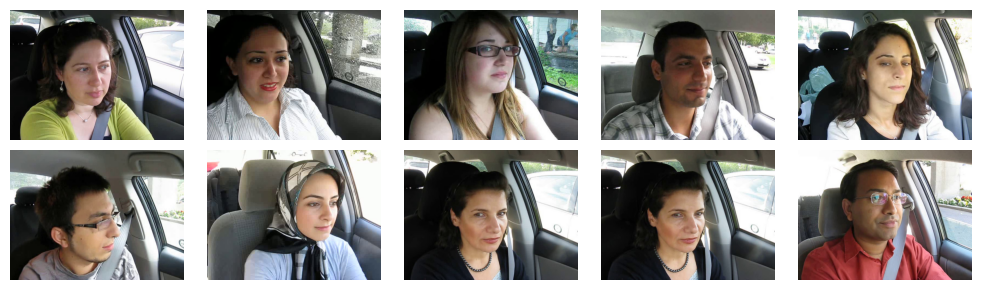

In [ ]:
# https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset/data
# Define paths for source (your dataset)
source_dir =  'Drowsiness_dataset'

no_yawn_path = source_dir + '/train/no_yawn'

# Get the list of image files in the folder
image_files = os.listdir(no_yawn_path)

# Select 10 random images from the list
random_images = random.sample(image_files, 10)

# Set up a 2x5 grid for displaying images
fig, axes = plt.subplots(2, 5, figsize=(10, 3))

# Loop through the grid and display the random images
for i, ax in enumerate(axes.flat):
    img = mpimg.imread(os.path.join(no_yawn_path, random_images[i]))
    ax.imshow(img)
    ax.axis('off')  # Turn off axis for better display

plt.tight_layout()
plt.show()

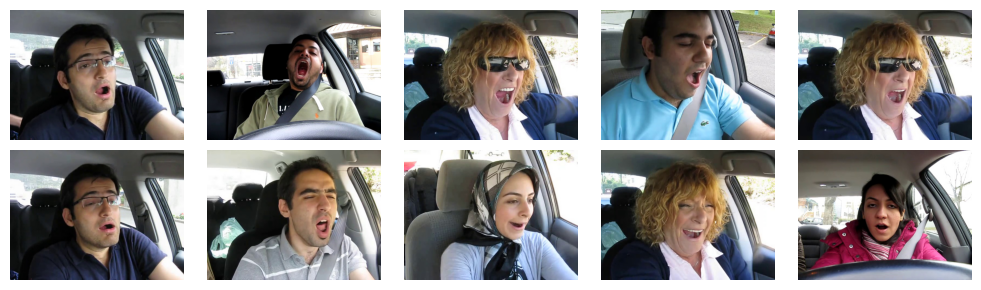

In [3]:
yawn_path = source_dir + '/train/yawn'

# Get the list of image files in the folder
image_files = os.listdir(yawn_path)

# Select 10 random images from the list
random_images = random.sample(image_files, 10)

# Set up a 2x5 grid for displaying images
fig, axes = plt.subplots(2, 5, figsize=(10, 3))

# Loop through the grid and display the random images
for i, ax in enumerate(axes.flat):
    img = mpimg.imread(os.path.join(yawn_path, random_images[i]))
    ax.imshow(img)
    ax.axis('off')  # Turn off axis for better display

plt.tight_layout()
plt.show()

In [ ]:
# Initialize dlib's face detector
detector = dlib.get_frontal_face_detector()

def crop_faces_and_save(source_dir, dest_dir, classes, train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15):
    """
    Detect faces, crop them, and save them into the appropriate directories for train, validation, and test.
    """
    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        
        # Shuffle images to ensure random distribution
        random.shuffle(images)
        
        # Split the images into train, validation, and test sets
        num_images = len(images)
        train_split = int(train_ratio * num_images)
        validation_split = int((train_ratio + validation_ratio) * num_images)
        
        # Create the class directories for train, validation, test
        for split in ['train', 'validation', 'test']:
            os.makedirs(os.path.join(dest_dir, split, class_name), exist_ok=True)
        
        # Process each image and crop the face
        for i, image_name in enumerate(images):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            
            # Skip if the image couldn't be loaded
            if img is None:
                print(f"Skipping image {image_name} (could not be loaded).")
                continue
            
            # Convert to grayscale (for face detection)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Detect faces
            faces = detector(gray)
            
            # If no faces detected, skip this image
            if len(faces) == 0:
                print(f"No faces detected in {image_name}. Skipping.")
                continue
            
            # For simplicity, we'll assume that the first face detected is the correct one
            for face in faces:
                x1, y1, x2, y2 = (face.left(), face.top(), face.right(), face.bottom())
                
                # Ensure that the bounding box coordinates are valid (non-negative and within bounds)
                if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
                    print(f"Invalid face bounding box in {image_name}. Skipping.")
                    continue
                
                cropped_face = img[y1:y2, x1:x2]
                
                # Check if the cropped face is valid (non-empty)
                if cropped_face.size == 0:
                    print(f"Empty cropped face in {image_name}. Skipping.")
                    continue
                
                # Resize cropped face to 90x90
                try:
                    cropped_face_resized = cv2.resize(cropped_face, (90, 90))
                except cv2.error as e:
                    print(f"Error resizing image {image_name}: {e}. Skipping.")
                    continue
                
                # Decide the folder based on split (train, validation, test)
                if i < train_split:
                    dest_folder = 'train'
                elif i < validation_split:
                    dest_folder = 'validation'
                else:
                    dest_folder = 'test'
                
                # Save the cropped face to the corresponding directory
                dest_path = os.path.join(dest_dir, dest_folder, class_name, image_name)
                save_img(dest_path, cropped_face_resized)
                print(f"Saved {image_name} to {dest_folder}/{class_name}")

# Define paths for destination (the split dataset)
dest_dir = 'Drowsiness_dataset/cropped_images'  # Modify this to your destination path

# Define the classes
classes = ['no_yawn', 'yawn']

# Call the function to crop faces and organize images into train, validation, and test sets
crop_faces_and_save(source_dir + '/train', dest_dir, classes)


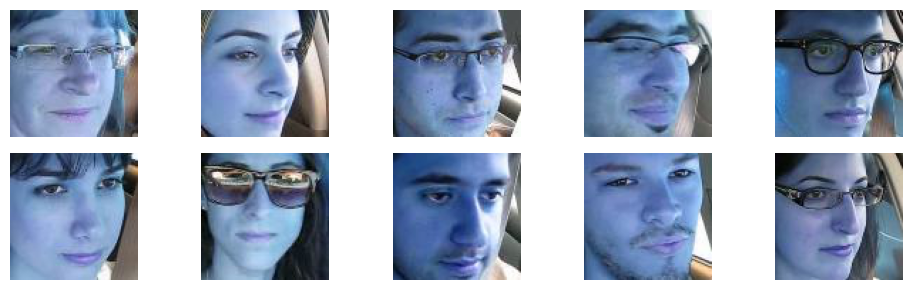

In [15]:
cropped_no_yawn_path = source_dir + '/cropped_images/train/no_yawn'

# Get the list of image files in the folder
image_files = os.listdir(cropped_no_yawn_path)

# Select 10 random images from the list
random_images = random.sample(image_files, 10)

# Set up a 2x5 grid for displaying images
fig, axes = plt.subplots(2, 5, figsize=(10, 3))

# Loop through the grid and display the random images
for i, ax in enumerate(axes.flat):
    img = mpimg.imread(os.path.join(cropped_no_yawn_path, random_images[i]))
    ax.imshow(img)
    ax.axis('off')  # Turn off axis for better display

plt.tight_layout()
plt.show()

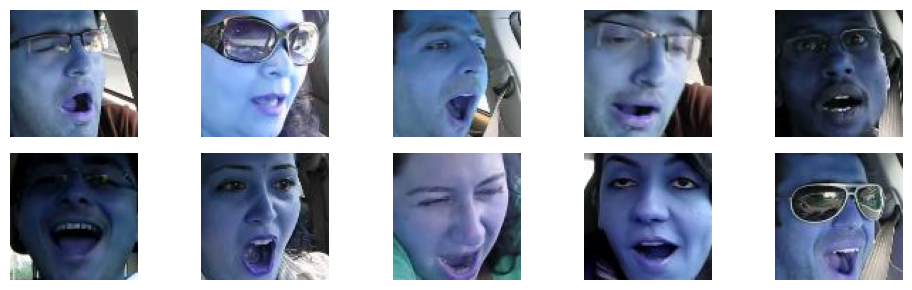

In [19]:
cropped_yawn_path = source_dir + '/cropped_images/train/yawn'

# Get the list of image files in the folder
image_files = os.listdir(cropped_yawn_path)

# Select 10 random images from the list
random_images = random.sample(image_files, 10)

# Set up a 2x5 grid for displaying images
fig, axes = plt.subplots(2, 5, figsize=(10, 3))

# Loop through the grid and display the random images
for i, ax in enumerate(axes.flat):
    img = mpimg.imread(os.path.join(cropped_yawn_path, random_images[i]))
    ax.imshow(img)
    ax.axis('off')  # Turn off axis for better display

plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers

# Paths to the split dataset
train_dir = 'Drowsiness_dataset/cropped_images/train'
validation_dir = 'Drowsiness_dataset/cropped_images/validation'
test_dir = 'Drowsiness_dataset/cropped_images/test'

# Set up the ImageDataGenerator with augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the images to the range [0, 1]
    rotation_range=30,  # Random rotations
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shearing
    zoom_range=0.2,  # Zooming
    horizontal_flip=True,  # Horizontal flip
    fill_mode='nearest'  # Filling in missing pixels after transformations
)

# Set up the ImageDataGenerator for the validation set (without augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Set up the ImageDataGenerator for the test set (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to the 'train' folder
    target_size=(90, 90),  # Resize all images to 90x90 (for CNN)
    batch_size=32,  # Number of images per batch
    class_mode='binary',  # 'binary' since we have 2 classes: 'no_yawn' and 'yawn'
)

# Load the validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,  # Path to the 'validation' folder
    target_size=(90, 90),  # Resize all images to 90x90 (for CNN)
    batch_size=32,  # Number of images per batch
    class_mode='binary',  # 'binary' since we have 2 classes: 'no_yawn' and 'yawn'
)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Path to the 'test' folder
    target_size=(90, 90),  # Resize all images to 90x90 (for CNN)
    batch_size=32,  # Number of images per batch
    class_mode='binary',  # 'binary' since we have 2 classes: 'no_yawn' and 'yawn'
)

# Build and compile the CNN model (same as before)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(90, 90, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Found 925 images belonging to 2 classes.
Found 282 images belonging to 2 classes.
Found 259 images belonging to 2 classes.


c:\Users\Leon\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


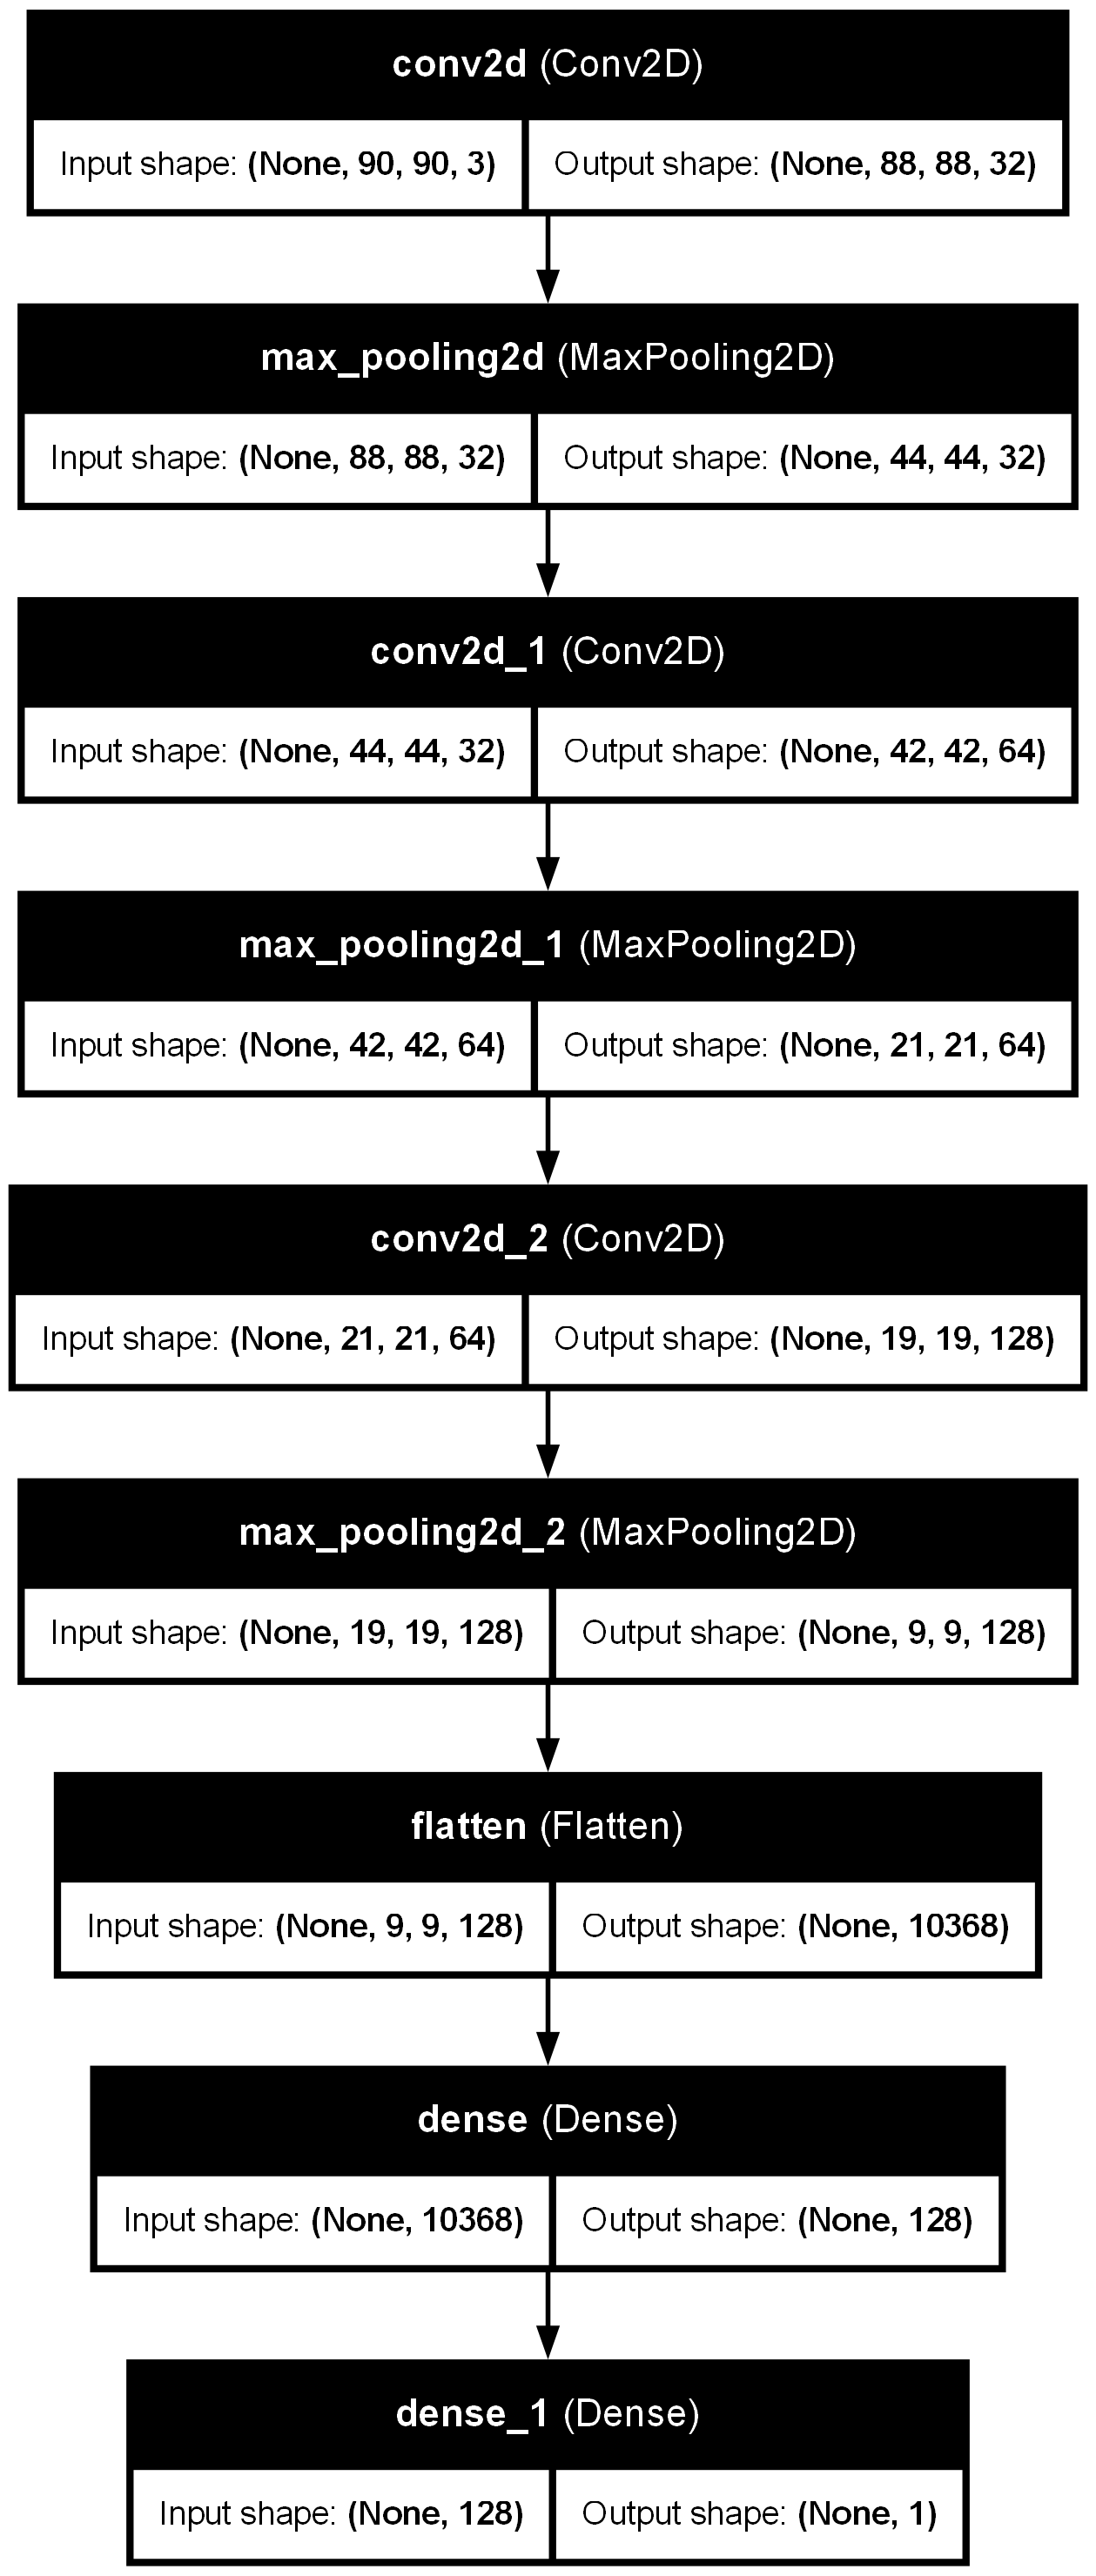

In [22]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='yawn_model_architecture.png', show_shapes=True, show_layer_names=True)

In [5]:
# Train the model using the augmented data
model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=100,  # Number of batches per epoch (adjust this as needed)
    epochs=10,  # Number of epochs
    validation_data=validation_generator,  # Validation data generator
    validation_steps=50  # Number of validation batches per epoch
)

# Evaluate on the test set after training
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")


c:\Users\Leon\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 29/100 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.5206 - loss: 0.7353

c:\Users\Leon\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5378 - loss: 0.7112 - val_accuracy: 0.7199 - val_loss: 0.6010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7045 - loss: 0.5832 - val_accuracy: 0.7660 - val_loss: 0.4638
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7490 - loss: 0.5121 - val_accuracy: 0.8759 - val_loss: 0.3286
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7745 - loss: 0.4878 - val_accuracy: 0.9078 - val_loss: 0.3352
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8038 - loss: 0.4676 - val_accuracy: 0.9043 - val_loss: 0.2993
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7991 - loss: 0.4470 - val_accuracy: 0.8865 - val_loss: 0.2791
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8168 - loss: 0.4309 - val_accuracy: 0.9007 - val_loss: 0.3176
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8009 - loss: 0.4565 - val_accuracy: 0.900

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


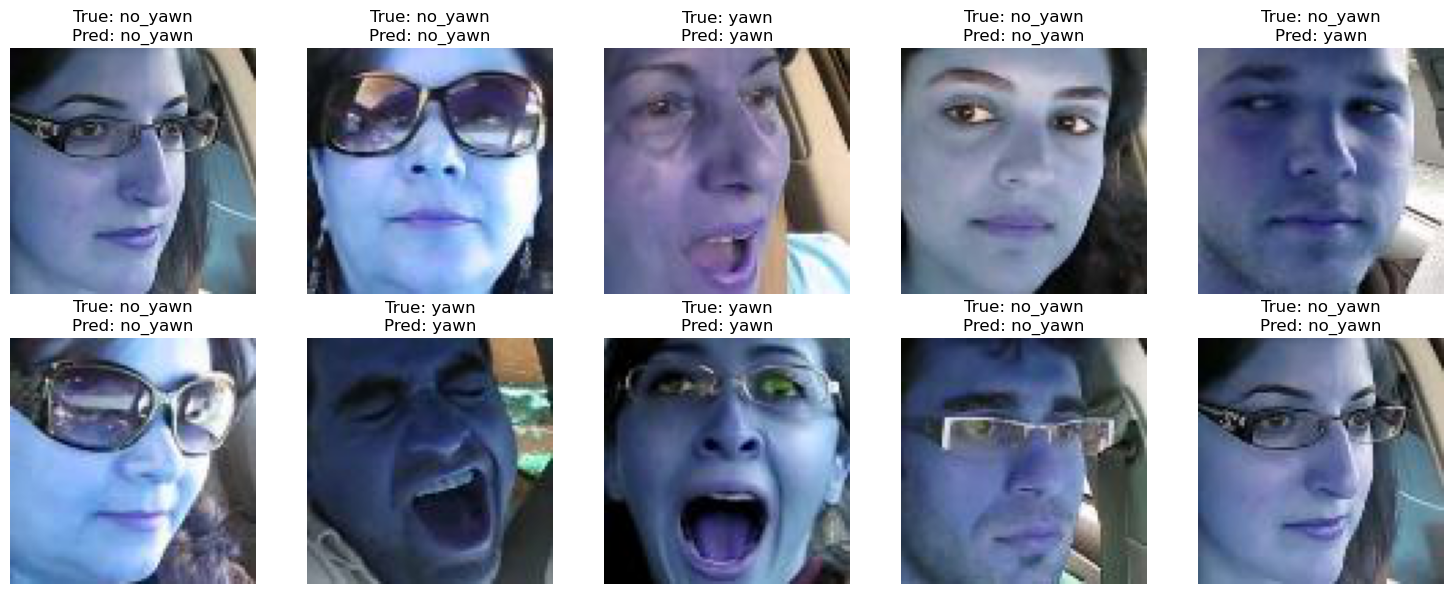

In [34]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the folder containing subfolders 'no_yawn' and 'yawn'
folder_path = 'Drowsiness_dataset/cropped_images/test'

# Get the list of image files from both 'no_yawn' and 'yawn' subfolders
no_yawn_folder = os.path.join(folder_path, 'no_yawn')
yawn_folder = os.path.join(folder_path, 'yawn')

# Get a list of image files from both folders
no_yawn_images = os.listdir(no_yawn_folder)
yawn_images = os.listdir(yawn_folder)

# Combine images from both folders and shuffle them
all_images = [(os.path.join(no_yawn_folder, img), 'no_yawn') for img in no_yawn_images] + \
             [(os.path.join(yawn_folder, img), 'yawn') for img in yawn_images]
random.shuffle(all_images)

# Select 10 random images
random_images = all_images[:10]

# Set up a 2x5 grid for displaying images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Loop through the random images and make predictions
for i, ax in enumerate(axes.flat):
    img_path, true_label = random_images[i]
    
    # Load the image and resize it to the required size (90x90)
    img = load_img(img_path, target_size=(90, 90))

    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Rescale the image (since we used rescale=1./255 in ImageDataGenerator)
    img_array = img_array / 255.0

    # Add batch dimension (the model expects a batch of images, so we need to add the extra dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make the prediction
    prediction = model.predict(img_array)

    # Since it's binary classification, if prediction > 0.5, we consider it as 'yawn', otherwise 'no_yawn'
    predicted_class = 'yawn' if prediction[0] > 0.5 else 'no_yawn'

    # Display the image
    ax.imshow(img)
    ax.axis('off')  # Hide axes

    # Set the title with the prediction
    ax.set_title(f"True: {true_label}\nPred: {predicted_class}")

plt.tight_layout()
plt.show()

In [7]:
# Save the model
model.save('yawn_model.h5')